In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import time

In [2]:
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor,
)
import torch
from torch.nn import MSELoss
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import glob
from pathlib import Path

from src.data_models.camels_ch import CamelsCH, CamelsCHConfig, get_all_gauge_ids
from src.data_models.dataset import HydroDataset
from src.data_models.preprocessing import (
    scale_time_series,
    scale_static_attributes,
    inverse_scale_static_attributes,
    inverse_scale_time_series,
)
from src.data_models.caravanify import Caravanify, CaravanifyConfig

from utils.metrics import nash_sutcliffe_efficiency
from src.data_models.datamodule import HydroTransferDataModule, HydroDataModule

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from src.preprocessing.transformers import GroupedTransformer, LogTransformer

In [3]:
from src.models.lstm import LitLSTM
from src.models.ealstm import LitEALSTM
from src.models.TSMixer import LitTSMixer, TSMixerConfig
from src.models.TSMixerDomainAdaptation import LitTSMixerDomainAdaptation
from src.models.evaluators import TSForecastEvaluator
from torch.optim import Adam
from torch.nn import MSELoss

---

## Central Asia

In [4]:
# Configuration for loading Central Asian (CA) hydrology data
CA_config = CaravanifyConfig(
    attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CA/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CA/post_processed/timeseries/csv",
    gauge_id_prefix="CA",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)

# Initialize Caravan data loader and load first 3 stations for training
CA_caravan = Caravanify(CA_config)
ids_for_training = CA_caravan.get_all_gauge_ids()[14:17]
print(f"Total number of stations: {len(ids_for_training)}")
CA_caravan.load_stations(ids_for_training)

# Get time series and static data
CA_ts_data = CA_caravan.get_time_series()
CA_static_data = CA_caravan.get_static_attributes()

# Process time series data
CA_ts_data["date"] = pd.to_datetime(CA_ts_data["date"])
CA_ts_data["julian_day"] = CA_ts_data["date"].dt.dayofyear

# Select relevant time series features
ts_columns = ["streamflow", "total_precipitation_sum"]
CA_ts_data = CA_ts_data[ts_columns + ["gauge_id", "date"]]

# Select relevant static features that characterize catchment properties
static_columns = [
    "gauge_id", "p_mean", "area", "ele_mt_sav", "high_prec_dur",
    "frac_snow", "high_prec_freq", "slp_dg_sav", "cly_pc_sav",
    "aridity_ERA5_LAND", "aridity_FAO_PM"
]
CA_static_data = CA_static_data[static_columns]

# Separate features from target variable
features = [col for col in CA_ts_data.columns if col not in ["gauge_id", "date", "streamflow"]]
ts_columns = features + ["streamflow"]

feature_pipeline = Pipeline([
    ("log", LogTransformer()), 
    ("scaler", StandardScaler())
])

target_pipeline = GroupedTransformer(
    Pipeline([("log", LogTransformer()), ("scaler", StandardScaler())]),
    columns=["streamflow"],
    group_identifier="gauge_id",
)

static_pipeline = Pipeline([("scaler", StandardScaler())])

preprocessing_configs = {
    "features": {"pipeline": feature_pipeline},
    "target": {"pipeline": target_pipeline},
    "static_features": {"pipeline": static_pipeline},
}

Total number of stations: 3


In [5]:
batch_size = 128
output_length = 10
input_length = 64
hidden_size = 32

# Create data module with the trial's batch size and input length
CA_data_module = HydroDataModule(
    time_series_df=CA_ts_data,
    static_df=CA_static_data,
    group_identifier="gauge_id",
    preprocessing_config=preprocessing_configs,
    batch_size=batch_size,  # Use trial's batch size
    input_length=input_length,  # Use trial's input length
    output_length=output_length,
    num_workers=4,
    features=ts_columns,
    static_features=static_columns,
    target="streamflow",
    min_train_years=2,
    val_years=1,
    test_years=3,
    max_missing_pct=10,
    domain_id="target",
)

CA_data_module.prepare_data()
CA_data_module.setup()

Original basins: 3
Retained basins: 3
Domain target: Created 18954 valid sequences from 3 catchments
Domain target: Created 876 valid sequences from 3 catchments
Domain target: Created 2855 valid sequences from 3 catchments


## Switzerland 

In [6]:
# Configuration for loading Central Asian (CA) hydrology data
CH_config = CaravanifyConfig(
    attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CH/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CH/post_processed/timeseries/csv",
    gauge_id_prefix="CH",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)

# Initialize Caravan data loader and load first 3 stations for training
CH_caravan = Caravanify(CH_config)
ids_for_training = CH_caravan.get_all_gauge_ids()[14:17]
print(f"Total number of stations: {len(ids_for_training)}")
CH_caravan.load_stations(ids_for_training)

# Get time series and static data
CH_ts_data = CH_caravan.get_time_series()
CH_static_data = CH_caravan.get_static_attributes()

# Process time series data
CH_ts_data["date"] = pd.to_datetime(CH_ts_data["date"])
CH_ts_data["julian_day"] = CH_ts_data["date"].dt.dayofyear

# Select relevant time series features
ts_columns = ["streamflow", "total_precipitation_sum"]
CH_ts_data = CH_ts_data[ts_columns + ["gauge_id", "date"]]

# Select relevant static features that characterize catchment properties
static_columns = [
    "gauge_id", "p_mean", "area", "ele_mt_sav", "high_prec_dur",
    "frac_snow", "high_prec_freq", "slp_dg_sav", "cly_pc_sav",
    "aridity_ERA5_LAND", "aridity_FAO_PM"
]
CH_static_data = CH_static_data[static_columns]

# Separate features from target variable
features = [col for col in CH_ts_data.columns if col not in [
    "gauge_id", "date", "streamflow"]]
ts_columns = features + ["streamflow"]

# Define preprocessing pipelines:
# 1. Feature pipeline: Log transform followed by standardization
feature_pipeline = Pipeline([
    ("log", LogTransformer()),
    ("scaler", StandardScaler())
])

# 2. Target pipeline: Log transform and standardization per catchment
target_pipeline = GroupedTransformer(
    Pipeline([("log", LogTransformer()), ("scaler", StandardScaler())]),
    columns=["streamflow"],
    group_identifier="gauge_id",
)

# 3. Static feature pipeline: Only standardization needed
static_pipeline = Pipeline([("scaler", StandardScaler())])

# Combine all preprocessing configurations
preprocessing_configs = {
    "features": {"pipeline": feature_pipeline},
    "target": {"pipeline": target_pipeline},
    "static_features": {"pipeline": static_pipeline},
}

Total number of stations: 3


In [7]:
CH_data_module = HydroDataModule(
    time_series_df=CH_ts_data,
    static_df=CH_static_data,
    group_identifier="gauge_id",
    preprocessing_config=preprocessing_configs,
    batch_size=batch_size,  # Use trial's batch size
    input_length=input_length,  # Use trial's input length
    output_length=output_length,
    num_workers=4,
    features=ts_columns,
    static_features=static_columns,
    target="streamflow",
    min_train_years=2,
    val_years=1,
    test_years=3,
    max_missing_pct=10,
    domain_id="source",
)

CH_data_module.prepare_data()
CH_data_module.setup()



Original basins: 3
Retained basins: 3
Domain source: Created 39225 valid sequences from 3 catchments
Domain source: Created 876 valid sequences from 3 catchments
Domain source: Created 3069 valid sequences from 3 catchments


## Testing combined DataModule

In [8]:
# Create transfer datamodule
transfer_dm = HydroTransferDataModule(
    source_datamodule=CA_data_module,
    target_datamodule=CH_data_module,
    num_workers=4,
    mode="min_size",
)

# Show one batch of data
batch = next(iter(transfer_dm.train_dataloader()))
print(f"Batch type: {type(batch)}")

# Since it's a tuple, we need to access elements by index
data_dict, _, _ = batch
source_batch = data_dict["source"]
target_batch = data_dict["target"]

# Print source batch information
print("\nSource batch keys:", source_batch.keys())
print("Source X shape:", source_batch["X"].shape)
print("Source static shape:", source_batch["static"].shape)
print("Source y shape:", source_batch["y"].shape)

# Print target batch information
print("\nTarget batch keys:", target_batch.keys())
print("Target X shape:", target_batch["X"].shape)
print("Target static shape:", target_batch["static"].shape)
print("Target y shape:", target_batch["y"].shape)

Batch type: <class 'tuple'>

Source batch keys: dict_keys(['X', 'y', 'static', 'domain_id', 'gauge_id', 'slice_idx'])
Source X shape: torch.Size([128, 64, 2])
Source static shape: torch.Size([128, 10])
Source y shape: torch.Size([128, 10])

Target batch keys: dict_keys(['X', 'y', 'static', 'domain_id', 'gauge_id', 'slice_idx'])
Target X shape: torch.Size([128, 64, 2])
Target static shape: torch.Size([128, 10])
Target y shape: torch.Size([128, 10])


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from src.models.TSMixerDomainAdaptation import TSMixerDomainAdaptationConfig

# 1. Create the domain adaptation config
domain_adaptation_config = TSMixerDomainAdaptationConfig(
    input_len=input_length,
    input_size=2,
    output_len=output_length,
    static_size=10,
    hidden_size=hidden_size,
    lambda_adv=1.0,
    domain_loss_weight=0.1,
    group_identifier="gauge_id"
)

# 2. Initialize the model with domain adaptation config
model = LitTSMixerDomainAdaptation(config=domain_adaptation_config)

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="cpu",
    devices=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
    enable_progress_bar=True
)

trainer.fit(model, transfer_dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name                 | Type                | Params | Mode 
---------------------------------------------------------------------
0 | model                | TSMixer             | 27.2 K | train
1 | domain_discriminator | DomainDiscriminator | 2.1 K  | train
2 | mse_criterion        | MSELoss             | 0      | train
3 | domain_criterion     | BCELoss             | 0      | train
---------------------------------------------------------------------
29.3 K    Trainable params
0         Non-trainable params
29.3 K    Total params
0.117     Total estimated model params size (MB)
104       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [10]:
trainer.test(model, CA_data_module)
raw_results = model.test_results

# Create evaluator and get metrics
evaluator = TSForecastEvaluator(
    CA_data_module, horizons=list(range(1, model.config.output_len + 1))
)
results_df, overall_metrics, basin_metrics = evaluator.evaluate(raw_results)

# Get overall summary
overall_summary = evaluator.summarize_metrics(overall_metrics)

# Get per-basin summary
basin_summary = evaluator.summarize_metrics(basin_metrics, per_basin=True)

Original basins: 3
Retained basins: 3
Domain target: Created 2855 valid sequences from 3 catchments


Testing: |          | 0/? [00:00<?, ?it/s]

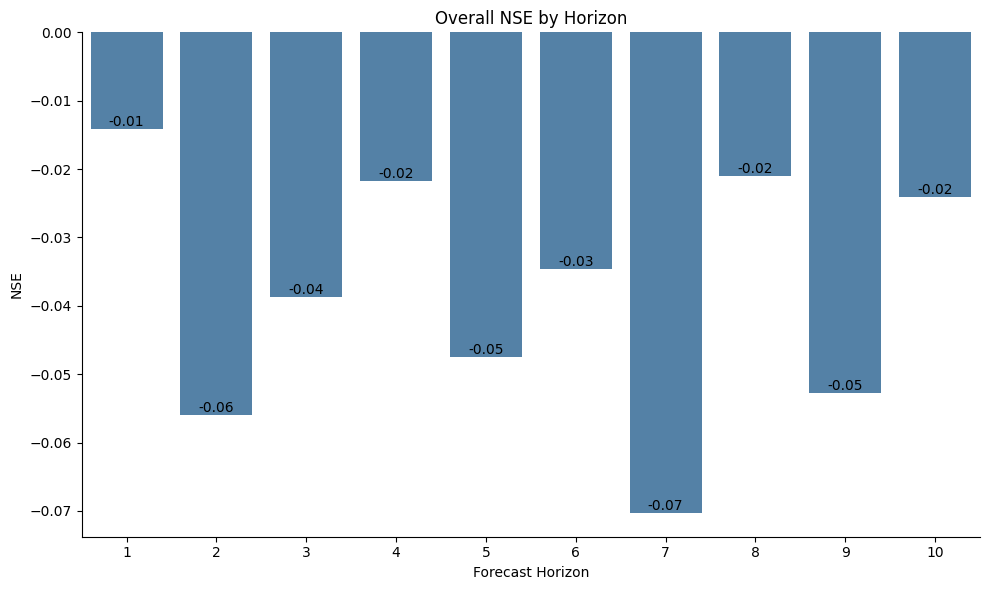

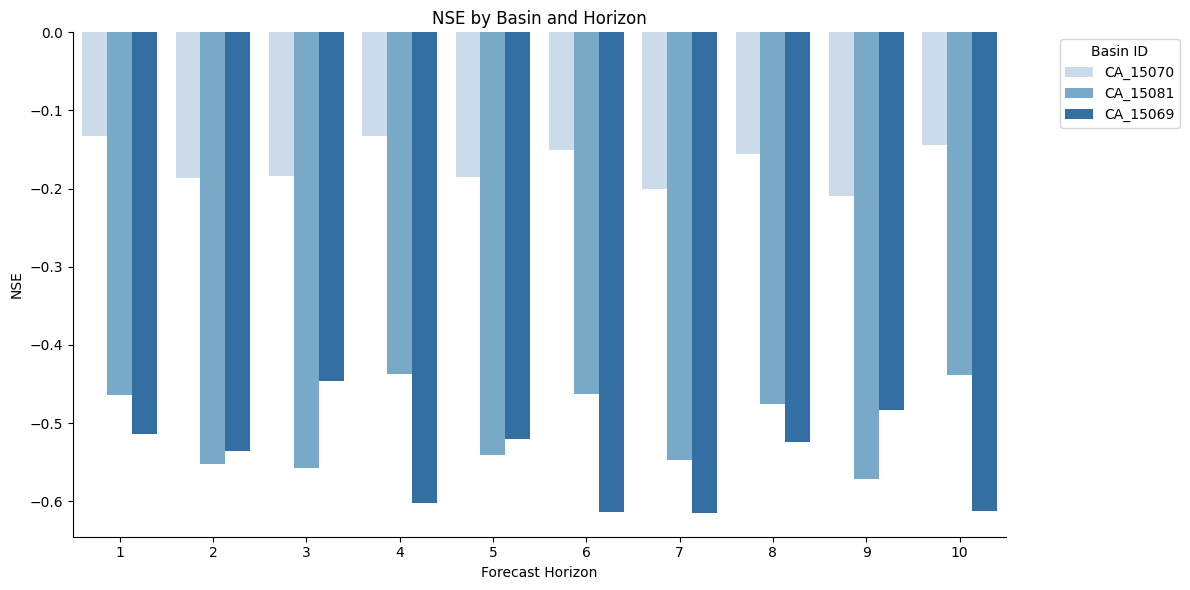

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_metric_summary(
    summary_df: pd.DataFrame, metric: str, per_basin: bool = False, figsize=(10, 6)
):
    plt.figure(figsize=figsize)

    if per_basin:
        df_plot = summary_df[metric].unstack(level=0)

        # Sort basins based on first horizon values
        first_horizon_values = df_plot.iloc[0]
        sorted_basins = first_horizon_values.sort_values(ascending=False).index
        df_plot = df_plot[sorted_basins]

        sns.barplot(
            data=df_plot.melt(ignore_index=False).reset_index(),
            x="horizon",
            y="value",
            hue="basin_id",
            palette="Blues",
        )
        plt.title(f"{metric} by Basin and Horizon")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Basin ID")

    else:
        ax = sns.barplot(x=summary_df.index, y=summary_df[metric], color="steelblue")
        plt.title(f"Overall {metric} by Horizon")

        for i, v in enumerate(summary_df[metric]):
            ax.text(i, v, f"{v:.2f}", ha="center", va="bottom")

    plt.xlabel("Forecast Horizon")
    plt.ylabel(metric)
    plt.tight_layout()
    sns.despine()
    plt.show()


# Usage example:
plot_metric_summary(overall_summary, "NSE")  # Plot overall NSE
plot_metric_summary(
    basin_summary, "NSE", per_basin=True, figsize=(12, 6)
)  

## Now with lambda set to 0

In [12]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from src.models.TSMixerDomainAdaptation import TSMixerDomainAdaptationConfig

# 1. Create the domain adaptation config
domain_adaptation_config = TSMixerDomainAdaptationConfig(
    input_len=input_length,
    input_size=2,
    output_len=output_length,
    static_size=10,
    hidden_size=hidden_size,
    lambda_adv=0.0,
    domain_loss_weight=0.0,
    group_identifier="gauge_id"
)

# 2. Initialize the model with domain adaptation config
model = LitTSMixerDomainAdaptation(config=domain_adaptation_config)

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="cpu",
    devices=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3)],
    enable_progress_bar=True
)

trainer.fit(model, transfer_dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name                 | Type                | Params | Mode 
---------------------------------------------------------------------
0 | model                | TSMixer             | 27.2 K | train
1 | domain_discriminator | DomainDiscriminator | 2.1 K  | train
2 | mse_criterion        | MSELoss             | 0      | train
3 | domain_criterion     | BCELoss             | 0      | train
---------------------------------------------------------------------
29.3 K    Trainable params
0         Non-trainable params
29.3 K    Total params
0.117     Total estimated model params size (MB)
104       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [13]:
trainer.test(model, CA_data_module)
raw_results = model.test_results

# Create evaluator and get metrics
evaluator = TSForecastEvaluator(
    CA_data_module, horizons=list(range(1, model.config.output_len + 1))
)
results_df, overall_metrics, basin_metrics = evaluator.evaluate(raw_results)

# Get overall summary
overall_summary = evaluator.summarize_metrics(overall_metrics)

# Get per-basin summary
basin_summary = evaluator.summarize_metrics(basin_metrics, per_basin=True)

Original basins: 3
Retained basins: 3
Domain target: Created 2855 valid sequences from 3 catchments


Testing: |          | 0/? [00:00<?, ?it/s]

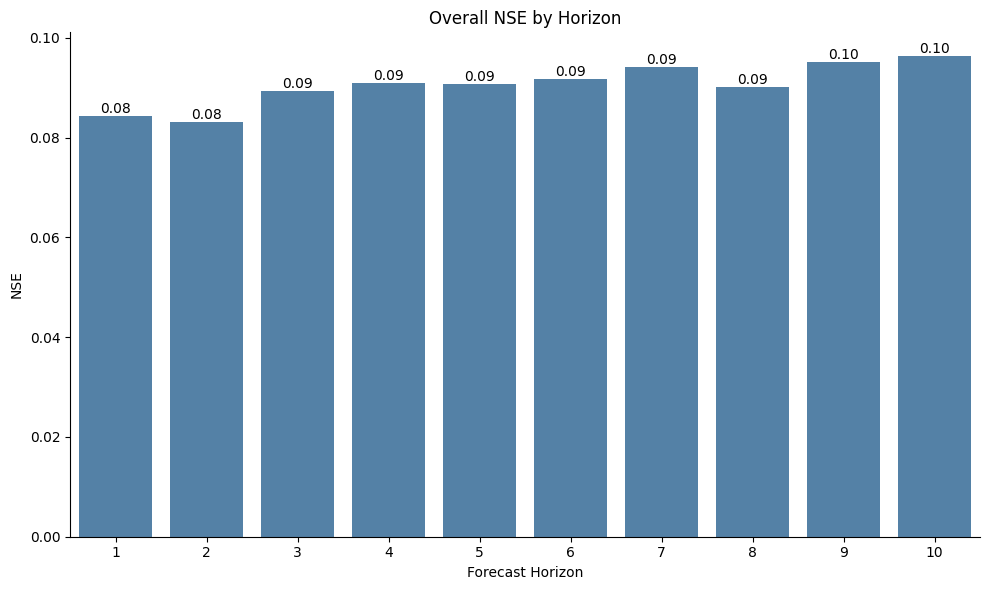

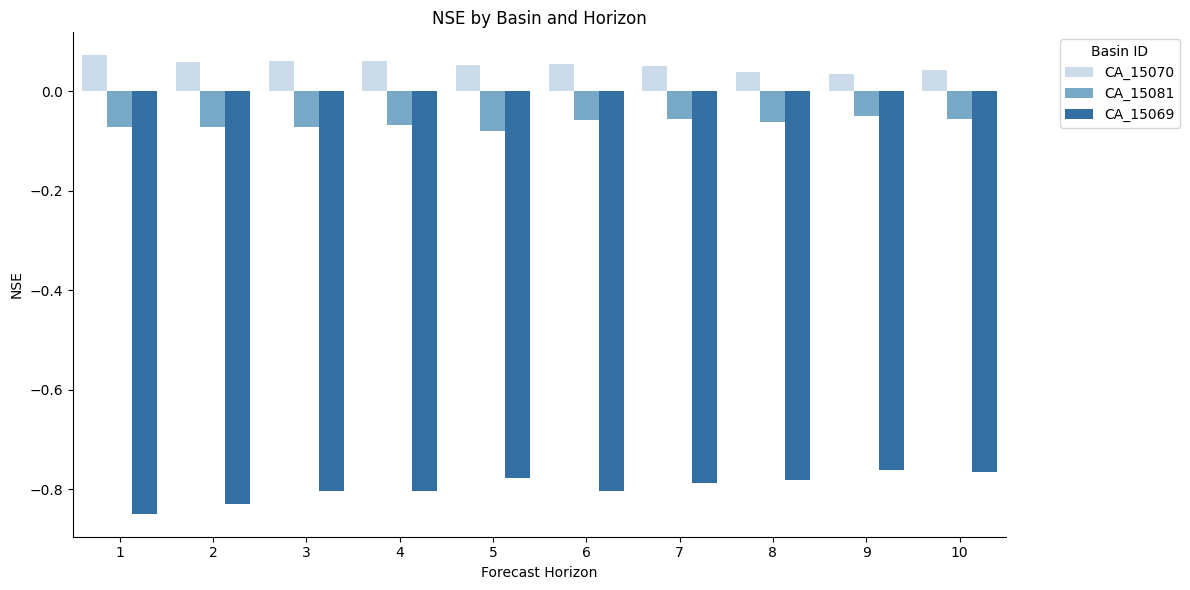

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_metric_summary(
    summary_df: pd.DataFrame, metric: str, per_basin: bool = False, figsize=(10, 6)
):
    plt.figure(figsize=figsize)

    if per_basin:
        df_plot = summary_df[metric].unstack(level=0)

        # Sort basins based on first horizon values
        first_horizon_values = df_plot.iloc[0]
        sorted_basins = first_horizon_values.sort_values(ascending=False).index
        df_plot = df_plot[sorted_basins]

        sns.barplot(
            data=df_plot.melt(ignore_index=False).reset_index(),
            x="horizon",
            y="value",
            hue="basin_id",
            palette="Blues",
        )
        plt.title(f"{metric} by Basin and Horizon")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Basin ID")

    else:
        ax = sns.barplot(x=summary_df.index, y=summary_df[metric], color="steelblue")
        plt.title(f"Overall {metric} by Horizon")

        for i, v in enumerate(summary_df[metric]):
            ax.text(i, v, f"{v:.2f}", ha="center", va="bottom")

    plt.xlabel("Forecast Horizon")
    plt.ylabel(metric)
    plt.tight_layout()
    sns.despine()
    plt.show()


# Usage example:
plot_metric_summary(overall_summary, "NSE")  # Plot overall NSE
plot_metric_summary(
    basin_summary, "NSE", per_basin=True, figsize=(12, 6)
)  